In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.4.1+cu124


/tmp/ipykernel_7511/189856270.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [2]:
import clip 

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
# rawmodel, preprocess = clip.load("ViT-B/32")
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

12
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
import torch
import torch.nn as nn
import numpy as np


def quantize_8b_codebook(tensor):
    
    # Create a codebook with 16 levels (4 bits)
    n_levels = 2**8
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    
    # Create codebook
    codebook = torch.linspace(min_val, max_val, n_levels).to('cuda')
    
    # Reshape tensor and codebook for broadcasting
    x_flat = tensor.reshape(-1, 1)
    
    # Find nearest codebook entry
    distances = torch.abs(x_flat - codebook)
    indices = torch.argmin(distances, dim=1)
    return indices.reshape(tensor.shape).to(torch.uint8), min_val.half(),(max_val-min_val)/n_levels

def dequantize_8b_codebook(indices, min_val , scale):
    """
    Dequantize using codebook
    """
    return min_val+indices*scale
class SDV_FC(nn.Module):
    def __init__(self, l1, l2, bias, remainder):
        super(SDV_FC, self).__init__()
        self.l1 = nn.Parameter(l1.clone()).half()
        self.l2 = nn.Parameter(l2.clone()).half()
        self.bias = nn.Parameter(bias.clone())
        self.remainder,self.min_val , self.scale=quantize_8b_codebook(remainder)
        self.scale=self.scale.half()
        del l1,l2,bias , remainder
        
    def forward(self, x):
        # Compute standard part
        standard_out = x @ self.l2.t() @ self.l1.t()
        
    
        # Compute remainder part
        remainder_out = x @ dequantize_8b_codebook(self.remainder,self.min_val , self.scale).t()
        
        # Combine all parts
        out = remainder_out + standard_out + self.bias
        return out


def SDV_FC_FullyConnectedLayers(fc_weight, fc_bias, rank=None):
    # Compute SVD
    U, S, Vh = torch.linalg.svd(fc_weight, full_matrices=False)
    
    # Verify S is sorted
    assert torch.all(S[:-1] >= S[1:]), "Singular values not sorted!"
    
    # Take components corresponding to non-zero singular values
    U_r = U[:, :rank]
    S_r = S[:rank]
    V_r = Vh[:rank, :]
    
    # Create scaled matrices
    l1 = U_r @ torch.diag(S_r)
    l2 = V_r
    remainder = fc_weight - l1 @ l2
    del fc_weight
    return SDV_FC(l1, l2, fc_bias, remainder)

def convert_sdv_quant(model: nn.Module):
    def _convert_sdv(module: nn.Module):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                r = 8
                # Create the SDV_FC replacement
                lora_layer = SDV_FC_FullyConnectedLayers(
                    child.weight.data.float(),
                    child.bias,
                    r
                )
                module._modules[name] = lora_layer
            _convert_sdv(child)
        return module
    
    return _convert_sdv(model)

In [5]:
model = model.half()

In [6]:
convert_sdv_quant(model)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): CustomMultiheadAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (q_proj): SDV_FC()
            (k_proj): SDV_FC()
            (v_proj): SDV_FC()
            (out_proj): SDV_FC()
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): SDV_FC()
            (gelu): GELU(approximate='none')
            (c_proj): SDV_FC()
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): CustomMultiheadAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (q_proj): SDV_FC()
            (k_p

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

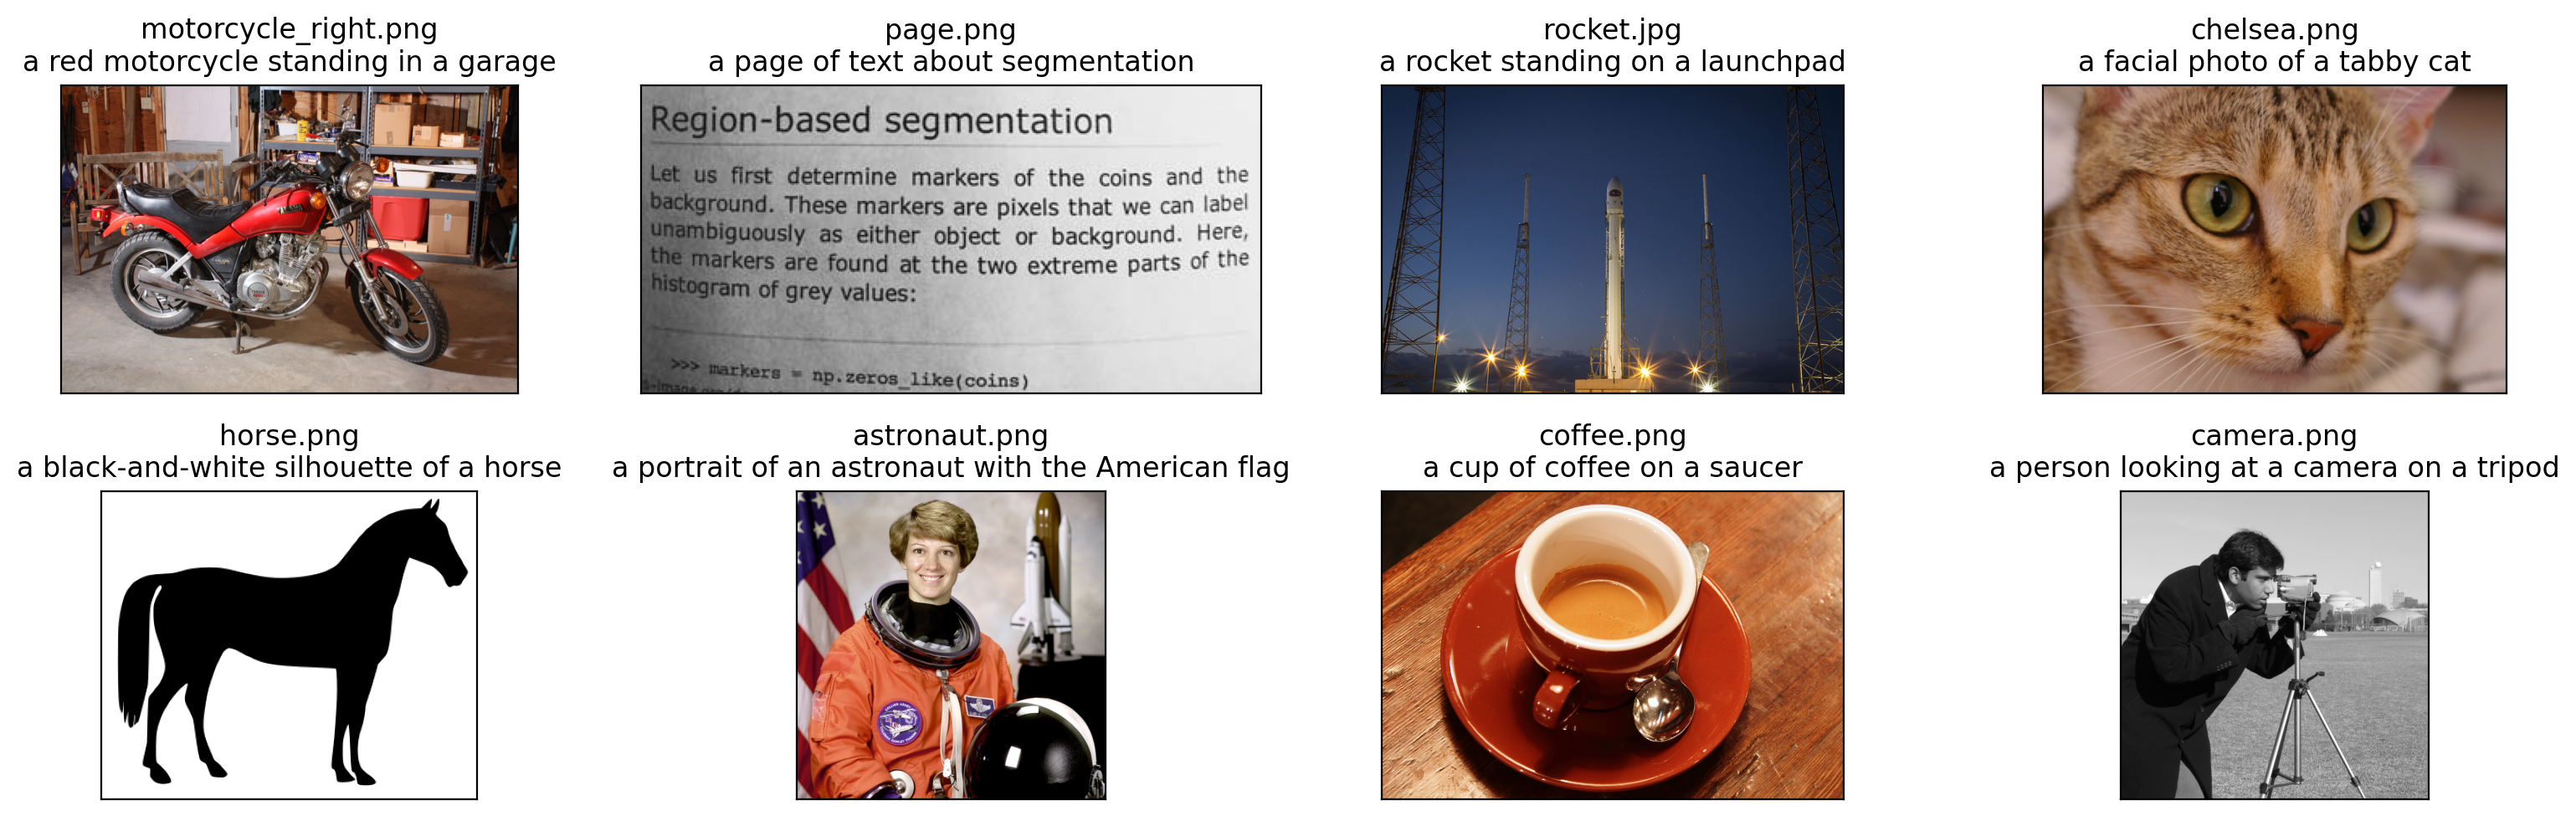

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [11]:
model.visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): CustomMultiheadAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (q_proj): SDV_FC()
          (k_proj): SDV_FC()
          (v_proj): SDV_FC()
          (out_proj): SDV_FC()
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): SDV_FC()
          (gelu): GELU(approximate='none')
          (c_proj): SDV_FC()
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): CustomMultiheadAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (q_proj): SDV_FC()
          (k_proj): SDV_FC()
          (v_proj): SDV_FC()
          (out_proj): SD

In [12]:
model.visual(image_input.type(model.dtype))

tensor([[ 0.4204,  0.2991, -0.1080,  ...,  0.5728, -0.0155,  0.2449],
        [ 0.2292,  0.3357, -0.2101,  ...,  0.6318,  0.5723,  0.1500],
        [ 0.0998,  0.1708, -0.0398,  ...,  0.0219, -0.2278, -0.5669],
        ...,
        [ 0.3372,  0.2585, -0.2036,  ..., -0.2278, -0.1453,  0.0364],
        [ 0.1539,  0.5630, -0.1212,  ...,  0.5684,  0.1271, -0.0553],
        [ 0.0187,  0.0637,  0.0213,  ...,  0.1221, -0.2883,  0.0860]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

In [13]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [14]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

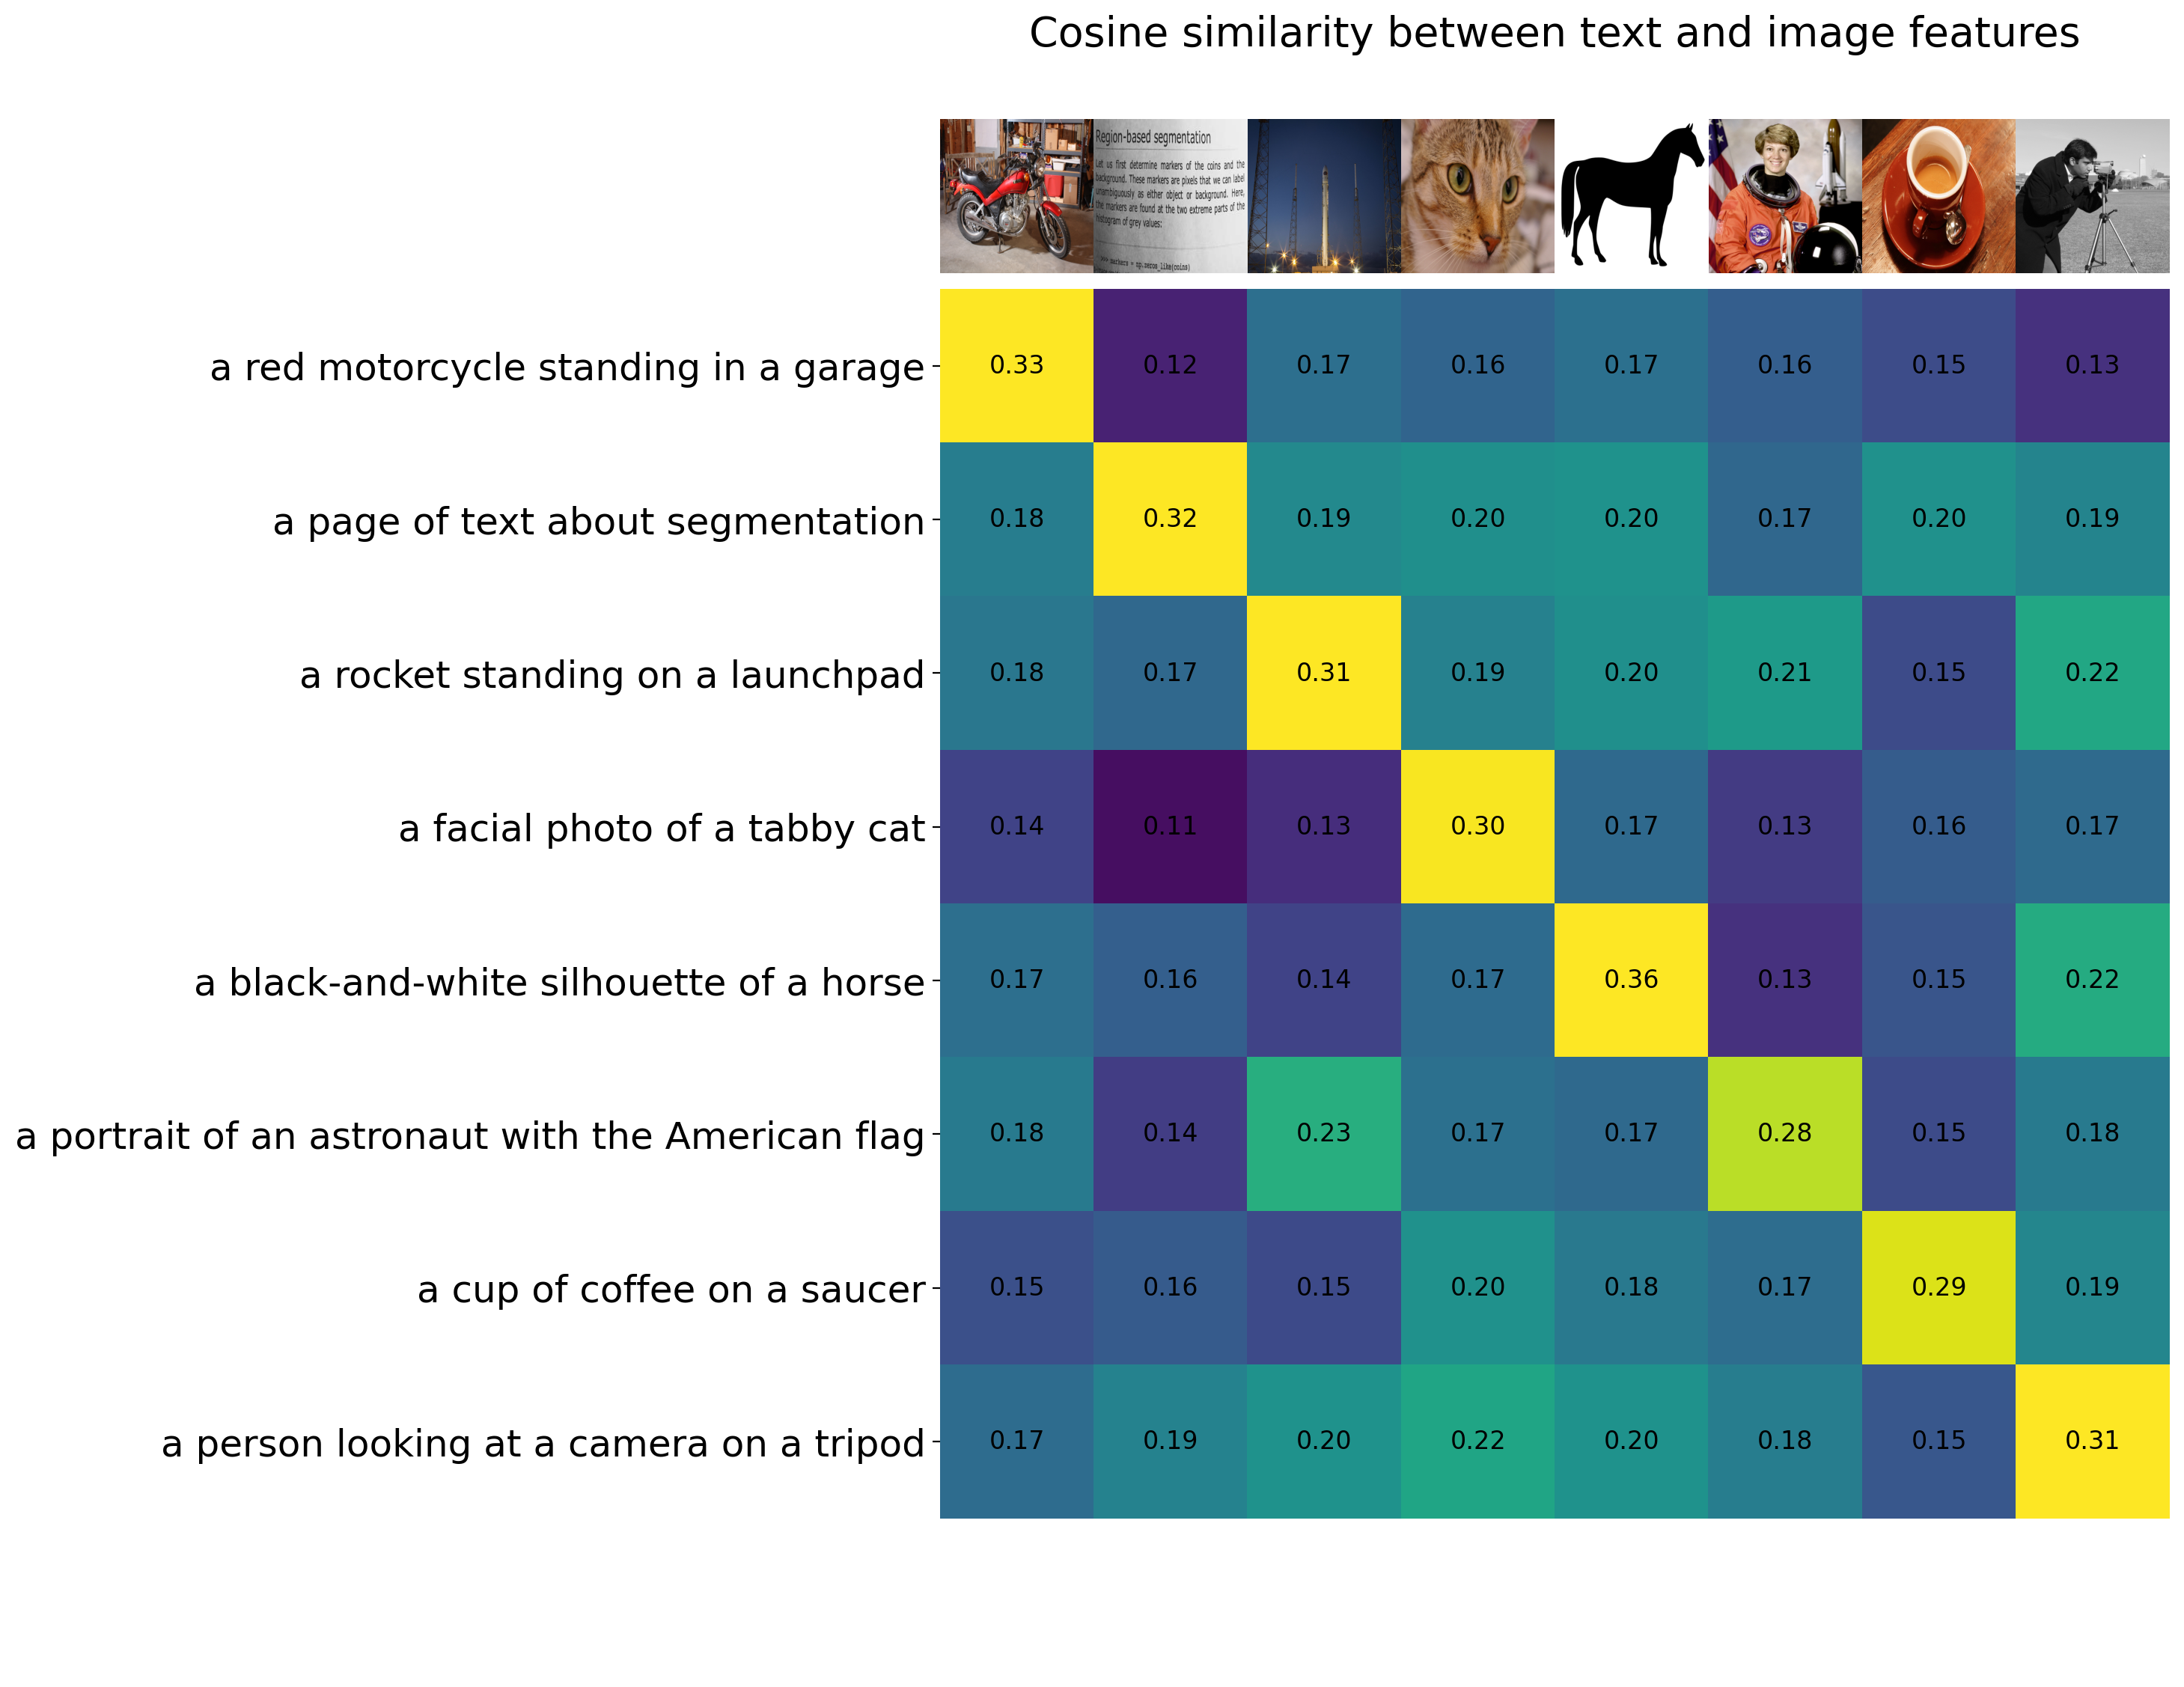

In [15]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [16]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [17]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [18]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

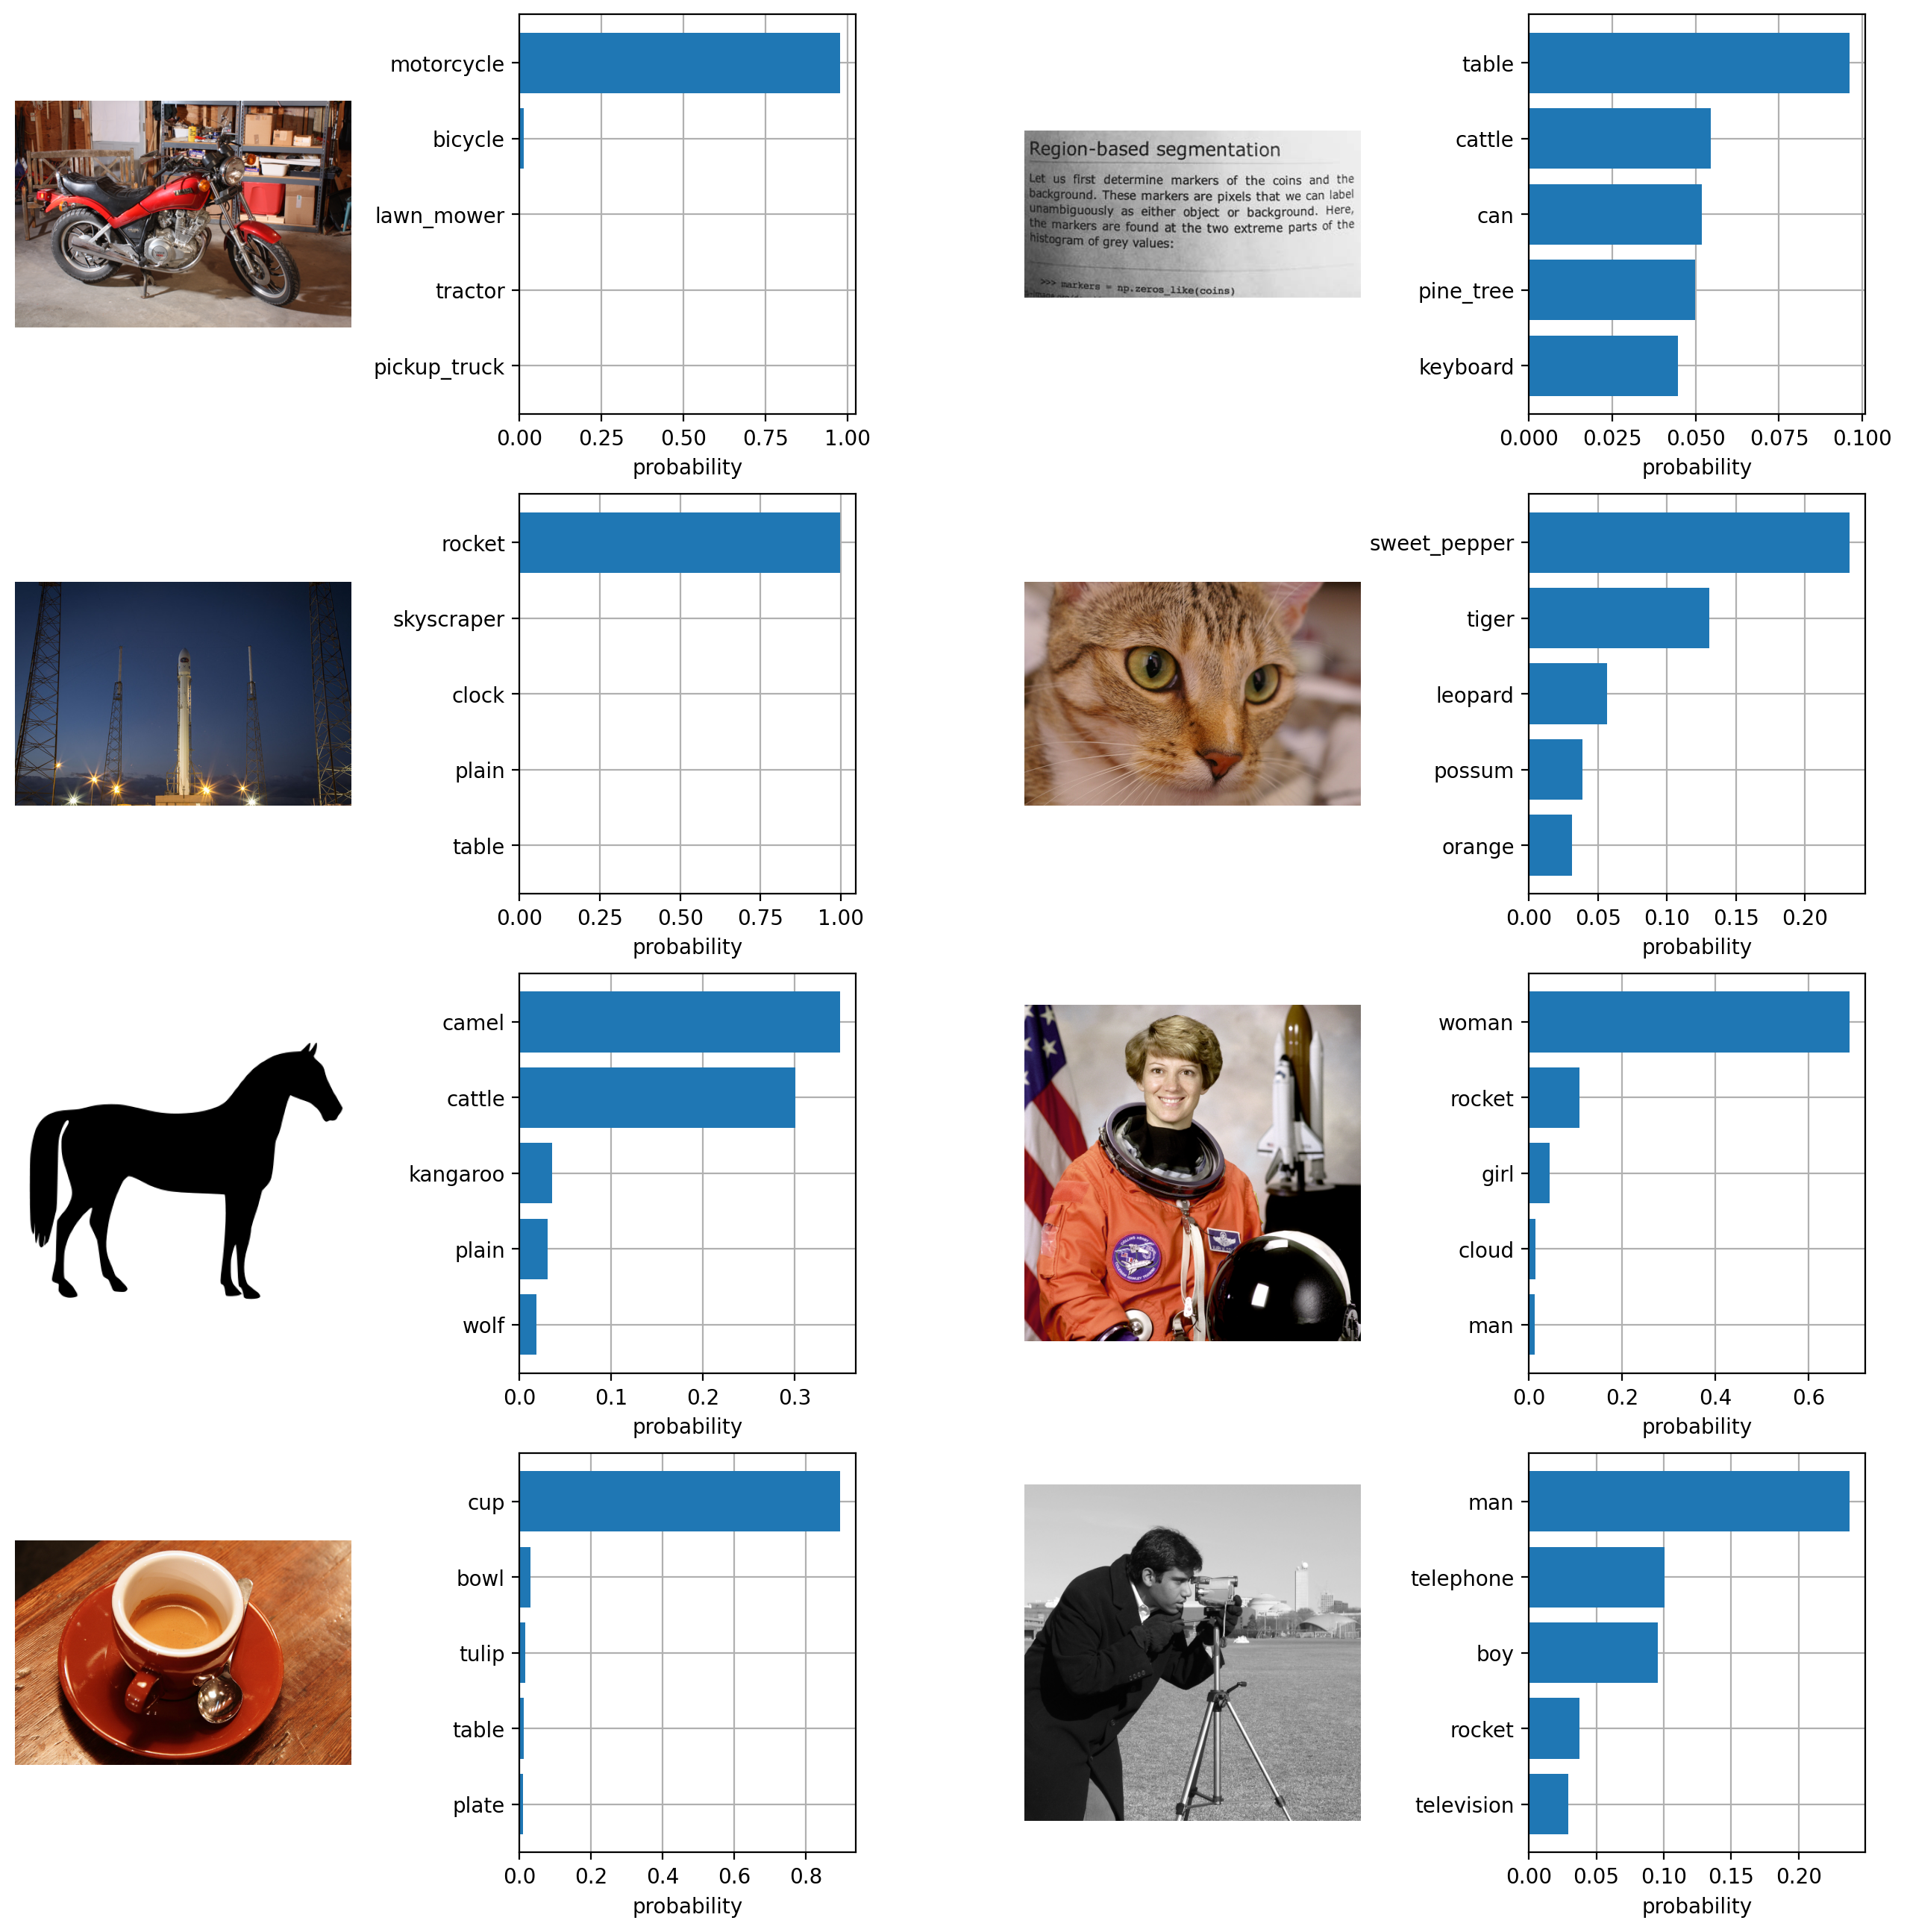

In [19]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [20]:
len(cifar100.classes)

100

In [21]:
import time
from torch.utils.data import DataLoader, Subset
device="cuda"
text_descriptions = [f"a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode text prompts once (and normalize)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Create DataLoader for CIFAR-100 (using a batch size that fits your GPU memory)
batch_size = 64  # Adjust batch size as needed
subset_indices = list(range(1024))
cifar100_subset = Subset(cifar100, subset_indices)
dataloader = DataLoader(cifar100_subset, batch_size=batch_size, shuffle=False)

# Variables to accumulate correct predictions and total count
top1_correct = 0
top5_correct = 0
total_samples = 0
start=time.time()
# Iterate over the dataset
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        total_samples += images.size(0)
        
        # Encode images using CLIP
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Compute the cosine similarity between image features and text features,
        # scaled by a temperature factor (here 100.0, as in the original CLIP paper)
        logits = 100.0 * image_features @ text_features.T
        
        # Convert logits to probabilities (optional for accuracy calculation)
        probs = logits.softmax(dim=-1)
        
        # Get the indices of the top 5 predictions
        top5_probs, top5_indices = probs.topk(5, dim=-1)
        
        # Top-1 prediction is the first element of top5_indices
        top1_predictions = top5_indices[:, 0]
        
        # Update top-1 correct count: compare the top1 prediction with the true label
        top1_correct += (top1_predictions == labels).sum().item()
        
        # Update top-5 correct count: check if true label is within the top 5 predictions
        # For each sample, this returns a boolean tensor that we sum up.
        top5_correct += sum([label in top5_indices[i] for i, label in enumerate(labels)])     
# Compute accuracies
print("time" , time.time()-start)
top1_accuracy = top1_correct / total_samples
top5_accuracy = top5_correct / total_samples

print(f"Total samples: {total_samples}")
print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")

time 5.774657487869263
Total samples: 1024
Top-1 Accuracy: 61.33%
Top-5 Accuracy: 85.16%


In [22]:
len(dataloader)

16

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 28593921


In [24]:
torch.save(model, 'model.pth')